In [2]:
#Set google drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Install miniconda and rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [4]:
#Read smiles files
with open('/content/gdrive/My Drive/Colab Notebooks/smiles.txt') as f:
  smiles = f.readlines()[:]
  smiles = [s.strip() for s in smiles]
  smiles = [s.split()[1] for s in smiles]
print (len(smiles))
print (smiles[:100])

482852
['O=[N+]([O-])c1ccc(O)c(/C=N/c2ccc3nccnc3c2)c1', 'CCOC(=O)C1CCCNC1=O', 'C/C(=N/O)C1=CC(C)(C)CCC1', 'Cc1cc(N/N=C/c2cccc([N+](=O)[O-])c2)nc(-n2nc(C)cc2C)n1', 'CCOc1ccc(C2NC(=O)NC(C)=C2C(=O)OCc2ccccc2)cc1', 'CC(/C=C/c1ccc2c3c(cccc13)CC2)=C\\C(=O)[O-].[Na+]', 'CC1(C)Cc2ccccc2/C(=C/C(=O)Nc2ccccc2[N+](=O)[O-])N1', 'Cc1cc(C)c(NC(=O)/C=C2\\NC(C)(C)Cc3ccccc32)c(C)c1.Cl', 'Cn1c(=O)c(C(=O)Nc2ccncc2)c(O)c2ccccc21', 'Cc1cc(O)nc(N2CCCCC2)n1', 'C(#Cc1ccccc1)CN1CCCCC1.Cl', 'O=C1NC(=O)C(=Cc2cn(-c3ccccc3)nc2-c2ccccc2)C(=O)N1', 'C=Cc1cc2ccccc2c2cc3c(cc12)C[N+](C)(C)C3.[Br-]', 'CCCCOc1ccc(C(CC(=O)O)C(=O)O)cc1', 'Cc1ccc(-c2cn3c4ccc5ccccc5c4nc3n2-c2ccc(C)cc2)cc1', 'CC(CC1OCC(C[N+]2(C)CCCCC2)O1)CC(C)(C)C.[I-]', 'CCOC(=O)C(Cc1ccc(OC)c([N+](=O)[O-])c1)NC(=O)CCC(=O)Nc1cccc([N+](=O)[O-])c1', 'O=C(OCc1ccccc1)Oc1cncc(C(=O)ON2C(=O)CCC2=O)c1', 'Cl.c1coc(CNCC2OCCc3ccccc32)c1', 'COCCOC(=O)c1c(C)oc2ccc(OC(=O)C(C)(C)C)cc12', 'CCCCn1nc(CC(=O)NCCN(CC)CC)c2ccccc2c1=O', 'C=CCN1C(=O)NC(=O)/C(=C/c2ccc(O)cc2)C1=O', 'CN1

In [6]:
#Calculate Morgan fingerprints and LogP of each molecule
from rdkit import Chem
from rdkit.Chem.Crippen import MolLogP
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
import torch
import time

X, Y = [], []
num_data = 20000
st = time.time()
for s in smiles[:num_data]:
  m = Chem.MolFromSmiles(s)
  fp = np.array(AllChem.GetMorganFingerprintAsBitVect(m,2, nBits=1024))
  logp = MolLogP(m)
  X.append(fp)
  Y.append(logp)
end = time.time()

#Convert to torch tensor
X = torch.from_numpy(np.array(X)).float()
Y = torch.from_numpy(np.array(Y)).float()

print (X.size())
print (Y.size())
print (f'Time:{(end-st):.3f}')

torch.Size([20000, 1024])
torch.Size([20000])
Time:67.461


In [12]:
#Divide training and test data
num_train = 19000
X_train = X[:num_train, :]
Y_train = Y[:num_train]
X_test = X[num_train:]
Y_test = Y[num_train:]

print (X_train.size())
print (f'Num train data: {len(X_train)}')
print (f'Num test data: {len(X_test)}')


torch.Size([19000, 1024])
Num train data: 19000
Num test data: 1000


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearRegressor(torch.nn.Module):
  def __init__(self, D_in, D_out, H):
    super(LinearRegressor, self).__init__()
    self.linear1 = nn.Linear(D_in, H)
    self.linear2 = nn.Linear(H, H)
    self.linear3 = nn.Linear(H, D_out)

  def forward(self, x):
    retval = self.linear1(x)
    retval = F.tanh(retval)
    retval = self.linear2(retval)
    retval = F.tanh(retval)
    retval = self.linear3(retval)
    return retval

In [0]:
#Train model
import time
lr = 1e-6
model = LinearRegressor(1024,1, 1024)

#Load model
model.load_state_dict(torch.load(fn))

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.MSELoss()
batch_size = 512
loss_list = []
st = time.time()

X_train = X_train.cuda()
Y_train = Y_train.cuda()
X_test = X_test.cuda()
Y_test = Y_test.cuda()
model = model.cuda()

for i in range(100001):
  idx = torch.randint(0, len(X_train), (batch_size,))
  x = X_train[idx,:]
  y = Y_train[idx]

  pred = model(x)
  pred = pred.squeeze(-1)
  loss = loss_fn(pred, y)
  loss.backward()
  optimizer.step()
  loss_list.append(loss.data.cpu().numpy())
  if i%1000==0:
    print (i, loss.data.cpu().numpy())
end = time.time()
print ('Time:', end-st)

In [0]:
#Save model
fn = '/content/gdrive/My Drive/save.pt'
torch.save(model.state_dict(), fn)

In [0]:
#Load model
model.load_state_dict(torch.load(fn))

Text(0, 0.5, 'Loss')

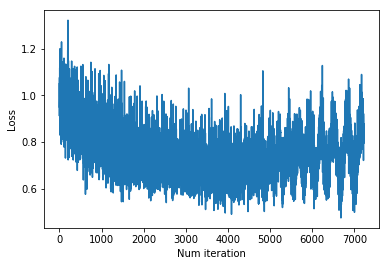

In [22]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.xlabel('Num iteration')
plt.ylabel('Loss')


In [23]:
#Test model
model.eval()
with torch.no_grad():
  y_pred_train = model(X_train).squeeze(-1)
  y_pred_test = model(X_test).squeeze(-1)

loss_train = loss_fn(Y_train, y_pred_train)
loss_test = loss_fn(Y_test, y_pred_test)

print ('Train loss:', loss_train.data.cpu().numpy())
print ('Test loss:', loss_test.data.cpu().numpy())

Train loss: 0.8551323
Test loss: 0.93722034


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Text(0, 0.5, 'Pred')

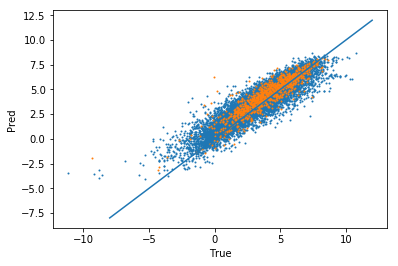

In [24]:

plt.scatter(Y_train.data.cpu().numpy(), y_pred_train.data.cpu().numpy(), s=1)
plt.scatter(Y_test.data.cpu().numpy(), y_pred_test.data.cpu().numpy(), s=1)
plt.plot([-8,12], [-8,12])
plt.xlabel('True')
plt.ylabel('Pred')
